In [ ]:
!pip install ipython-autotime
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 4.6 MB/s 
time: 407 µs (started: 2022-09-28 01:48:07 +00:00)


In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets
from torchsummary import summary

time: 2.45 s (started: 2022-09-28 01:48:07 +00:00)


In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


time: 75.3 ms (started: 2022-09-28 01:48:09 +00:00)


In [ ]:
#Building the initial Convolutional Block

class ConvBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
    super().__init__()

    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
    self.bn = nn.BatchNorm2d(out_channels)
    self.activation = nn.ReLU()

  def forward(self, x):
    x = self.conv(x)
    x = self.bn(x)
    x = self.activation(x)
    return x

time: 1.15 ms (started: 2022-09-28 01:48:09 +00:00)


In [ ]:
# Building Inception Block
class Inception(nn.Module):
  def __init__(self, in_channels, num1X1, num3X3_reduce, num3X3, num5X5_reduce, num5X5, pool_proj):
    super().__init__()

    self.block1 = nn.Sequential(
        ConvBlock(in_channels, num1X1, kernel_size = 1, stride = 1, padding = 0)
    )
    self.block2 = nn.Sequential(
        ConvBlock(in_channels, num3X3_reduce, kernel_size = 1, stride = 1, padding = 0),
        ConvBlock(num3X3_reduce, num3X3, kernel_size = 3, stride = 1, padding = 1)
    )
    self.block3 = nn.Sequential(
        ConvBlock(in_channels, num5X5_reduce, kernel_size = 1, stride = 1, padding = 0),
        ConvBlock(num5X5_reduce, num5X5, kernel_size = 5, stride = 1, padding = 2)
    )
    self.block4 = nn.Sequential(
        nn.MaxPool2d(3, stride = 1, padding = 1, ceil_mode = True),
        ConvBlock(in_channels, pool_proj, kernel_size=1, stride = 1, padding = 0)
    )

  def forward(self, x):

    block1 = self.block1(x)
    block2 = self.block2(x)
    block3 = self.block3(x)
    block4 = self.block4(x)

    return torch.cat([block1, block2, block3, block4], 1)



time: 2.53 ms (started: 2022-09-28 01:48:09 +00:00)


In [ ]:
class Auxiliary(nn.Module):
  def __init__(self, in_channels, num_classes):
    super().__init__()

    self.pool = nn.AdaptiveAvgPool2d((4, 4))
    self.conv = nn.Conv2d(in_channels,  128, kernel_size = 1 , stride = 1 , padding = 0)
    self.activation = nn.ReLU()


    self.fc1 = nn.Linear(2048, 1024)
    self.dropout = nn.Dropout(0.7)
    self.fc2 = nn.Linear(1024, num_classes)


  def forward(self, x):
    out = self.pool(x)

    out = self.conv(out)
    out = self.activation(out)

    out = torch.flatten(out, 1)

    out = self.fc1(out)
    out = self.activation(out)
    out = self.dropout(out)

    out = self.fc2(out)

    return out



time: 1.66 ms (started: 2022-09-28 01:48:09 +00:00)


In [ ]:
class GoogleNet(nn.Module):
  def __init__(self, num_classes = 10) -> None:
      super().__init__()

      self.conv1 = ConvBlock(3, 64, kernel_size=7, stride = 2, padding = 3)
      self.pool1 = nn.MaxPool2d(3, stride = 2, padding = 0, ceil_mode = True)
      self.conv2 = ConvBlock(64, 64, kernel_size = 1, stride = 1, padding = 0)
      self.conv3 = ConvBlock(64, 192, kernel_size = 3, stride = 1, padding = 1)
      self.pool2 = nn.MaxPool2d(3, stride = 2, padding = 0, ceil_mode = True)

      #equalizing number of channels
      self.conv4 = ConvBlock(256, 480, kernel_size = 1, stride = 1, padding = 0)
      self.conv5 = ConvBlock(480, 512, kernel_size = 1, stride = 1, padding = 0)
      self.conv6 = ConvBlock(512, 528, kernel_size = 1, stride = 1, padding = 0)
      self.conv7 = ConvBlock(528, 832, kernel_size = 1, stride = 1, padding = 0)
      self.conv8 = ConvBlock(832, 1024, kernel_size = 1, stride = 1, padding = 0)



      self.inception3A = Inception(
          in_channels = 192,
          num1X1 = 64,
          num3X3_reduce= 96,
          num3X3= 128,
          num5X5_reduce = 16,
          num5X5 = 32,
          pool_proj = 32
      )


      self.inception3B = Inception(
          in_channels = 256,
          num1X1 = 128,
          num3X3_reduce= 128,
          num3X3= 192,
          num5X5_reduce = 32,
          num5X5 = 96,
          pool_proj = 64
      )


      self.pool3 = nn.MaxPool2d(3, stride = 2, padding = 0, ceil_mode= True)

      self.inception4A = Inception(
          in_channels = 480,
          num1X1 = 192,
          num3X3_reduce= 96,
          num3X3= 208,
          num5X5_reduce = 16,
          num5X5 = 48,
          pool_proj = 64
      )
      self.inception4B = Inception(
            in_channels = 512,
            num1X1 = 160,
            num3X3_reduce = 112,
            num3X3 = 224,
            num5X5_reduce = 24,
            num5X5 = 64,
            pool_proj=64,
        )
      self.inception4C = Inception(
            in_channels = 512,
            num1X1 = 128,
            num3X3_reduce = 128,
            num3X3 = 256,
            num5X5_reduce = 24,
            num5X5 = 64,
            pool_proj = 64,
        )
      self.inception4D = Inception(
            in_channels = 512,
            num1X1 = 112,
            num3X3_reduce = 144,
            num3X3 = 288,
            num5X5_reduce = 32,
            num5X5 = 64,
            pool_proj = 64,
        )
      self.inception4E = Inception(
            in_channels = 528,
            num1X1 = 256,
            num3X3_reduce = 160,
            num3X3 = 320,
            num5X5_reduce = 32,
            num5X5 = 128,
            pool_proj = 128,
        )

      self.pool4 = nn.MaxPool2d(3, stride = 2, padding = 0, ceil_mode = True)

      self.inception5A = Inception(
            in_channels=832,
            num1X1 = 256,
            num3X3_reduce = 160,
            num3X3 = 320,
            num5X5_reduce = 32,
            num5X5 = 128,
            pool_proj = 128,
        )
      self.inception5B = Inception(
            in_channels = 832,
            num1X1 = 384,
            num3X3_reduce = 192,
            num3X3 = 384,
            num5X5_reduce = 48,
            num5X5 = 128,
            pool_proj = 128,
        )

      self.pool5 = nn.AdaptiveAvgPool2d((1, 1))

      self.dropout = nn.Dropout(0.4)
      self.fc = nn.Linear(1024, num_classes)

      self.aux4A = Auxiliary(512, num_classes)
      self.aux4D = Auxiliary(528, num_classes)




  def forward(self, x):

      out = self.conv1(x)
      out = self.pool1(out)
      out = self.conv2(out)
      out = self.conv3(out)
      out = self.pool2(out)

      out = self.inception3A(out)
      u = self.conv4(out)
      out = self.inception3B(out) + u

      out = self.pool3(out)

      u = self.conv5(out)
      out = self.inception4A(out) + u

      aux1 = self.aux4A(out)

      out = self.inception4B(out) + out
      out = self.inception4C(out) + out
      u = self.conv6(out)
      out = self.inception4D(out) + u

      aux2 = self.aux4D(out)
      u = self.conv7(out)
      out = self.inception4E(out) + u

      out = self.pool4(out)

      out = self.inception5A(out) + out
      u = self.conv8(out)
      out = self.inception5B(out) + u

      out = self.pool5(out)

      out = torch.flatten(out, 1)

      out = self.dropout(out)
      out = (self.fc(out) + aux1 + aux2 ) / 3

      return out, aux1, aux2


time: 7.06 ms (started: 2022-09-28 01:48:09 +00:00)


In [ ]:
model = GoogleNet()
model.to(device)
summary(model,(3, 96, 96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           9,472
       BatchNorm2d-2           [-1, 64, 48, 48]             128
              ReLU-3           [-1, 64, 48, 48]               0
         ConvBlock-4           [-1, 64, 48, 48]               0
         MaxPool2d-5           [-1, 64, 24, 24]               0
            Conv2d-6           [-1, 64, 24, 24]           4,160
       BatchNorm2d-7           [-1, 64, 24, 24]             128
              ReLU-8           [-1, 64, 24, 24]               0
         ConvBlock-9           [-1, 64, 24, 24]               0
           Conv2d-10          [-1, 192, 24, 24]         110,784
      BatchNorm2d-11          [-1, 192, 24, 24]             384
             ReLU-12          [-1, 192, 24, 24]               0
        ConvBlock-13          [-1, 192, 24, 24]               0
        MaxPool2d-14          [-1, 192,

In [ ]:
def my_plot(val_history, train_history , title, y_label):
    plt.figure(figsize=(10,5))
    plt.title(title)
    plt.plot(val_history,label="val")
    plt.plot(train_history,label="train")

    plt.xlabel("iterations")
    plt.ylabel(y_label)

    plt.legend()
    plt.show()


def train_model(model, train_loader, val_loader, criterion, optimizer):
    EPOCHS = 10
    train_samples_num = 45000
    val_samples_num = 5000

    train_epoch_loss_history, val_epoch_loss_history = [], []
    train_epoch_acc_hist, val_epoch_acc_hist = [], []

    for epoch in range(EPOCHS):

        train_running_loss = 0
        correct_train = 0

        model.train().cuda()

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            """ for every mini-batch during the training phase, we
            typically want to explicitly set the gradients
            to zero before starting to do backpropragation """
            optimizer.zero_grad()

            # Start the forward pass
            prediction0, aux_pred_1, aux_pred_2 = model(inputs)

            # Compute the loss.
            real_loss = criterion(prediction0, labels)
            aux_loss_1 = criterion(aux_pred_1, labels)
            aux_loss_2 = criterion(aux_pred_2, labels)

            loss = real_loss + 0.3 * aux_loss_1 + 0.3 * aux_loss_2

            # do backpropagation and update weights with step()# Backward pass.
            loss.backward()
            optimizer.step()

            # Update the running corrects
            _, predicted = torch.max(prediction0.data, 1)

            correct_train += (predicted == labels).float().sum().item()

            """ Compute batch loss
            multiply each average batch loss with batch-length.
            The batch-length is inputs.size(0) which gives the number total images in each batch.
            Essentially I am un-averaging the previously calculated Loss """
            train_running_loss += loss.data.item() * inputs.shape[0]

        train_epoch_loss = train_running_loss / train_samples_num
        train_epoch_loss_history.append(train_epoch_loss)
        train_acc = correct_train / train_samples_num
        train_epoch_acc_hist.append(train_acc)

        val_loss = 0
        correct_val = 0

        model.eval().cuda()

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass.
                prediction0, aux_pred_1, aux_pred_2 = model(inputs)

                # Compute the loss.
                real_loss = criterion(prediction0, labels)
                aux_loss_1 = criterion(aux_pred_1, labels)
                aux_loss_2 = criterion(aux_pred_2, labels)

                loss = real_loss + 0.3 * aux_loss_1 + 0.3 * aux_loss_2

                # Compute training accuracy.
                _, predicted = torch.max(prediction0.data, 1)
                correct_val += (predicted == labels).float().sum().item()

                # Compute batch loss.
                val_loss += loss.data.item() * inputs.shape[0]

            val_loss /= val_samples_num
            val_epoch_loss_history.append(val_loss)
            val_acc = correct_val / val_samples_num
            val_epoch_acc_hist.append(val_acc)


        info = "[For Epoch {}/{}]: train-loss = {:0.5f} | train-acc = {:0.3f} | val-loss = {:0.5f} | val-acc = {:0.3f}"

        print(
            info.format(
                epoch + 1, EPOCHS, train_epoch_loss, train_acc, val_loss, val_acc
            )
        )

        torch.save(
            model.state_dict(), "/content/sample_data/checkpoint{}".format(epoch + 1)
        )

    torch.save(model.state_dict(), "/content/sample_data/optimized_model")

    #Plotting

    my_plot(val_epoch_loss_history, train_epoch_loss_history , "Training and Validation Loss", "Loss")
    my_plot(val_epoch_acc_hist, train_epoch_acc_hist, "Training and Validation Accuracy", "Acc" )

    return train_epoch_loss_history, val_epoch_loss_history

time: 112 ms (started: 2022-09-28 01:48:22 +00:00)


In [ ]:
def dataloader_cifar():
    transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
      ])

    transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
      ])

    # Input Data in Google Drive
    train_dataset = datasets.CIFAR10('/content/drive/MyDrive/All_Datasets/CIFAR10', train=True, download=True, transform=transform_train)
    test_dataset = datasets.CIFAR10('/content/drive/MyDrive/All_Datasets/CIFAR10', train=False, download=True, transform=transform_test)

    # Split dataset into training set and validation set.
    train_dataset, val_dataset = random_split(train_dataset, (45000, 5000))

    print("Image shape of a random sample image : {}".format(train_dataset[0][0].numpy().shape), end = '\n\n')

    print("Training Set:   {} images".format(len(train_dataset)))
    print("Validation Set:   {} images".format(len(val_dataset)))
    print("Test Set:       {} images".format(len(test_dataset)))

    BATCH_SIZE = 128

    # Generate dataloader
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=10000, shuffle=False)

    return train_loader, val_loader, test_loader


time: 3.94 ms (started: 2022-09-28 01:48:23 +00:00)


In [ ]:
train_loader, val_loader, test_loader =  dataloader_cifar()


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/drive/MyDrive/All_Datasets/CIFAR10/cifar-10-python.tar.gz to /content/drive/MyDrive/All_Datasets/CIFAR10
Files already downloaded and verified
Image shape of a random sample image : (3, 32, 32)

Training Set:   45000 images
Validation Set:   5000 images
Test Set:       10000 images
time: 6.75 s (started: 2022-09-28 01:48:23 +00:00)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

time: 1.96 ms (started: 2022-09-28 01:48:29 +00:00)


[For Epoch 1/10]: train-loss = 2.48165 | train-acc = 0.442 | val-loss = 2.10702 | val-acc = 0.542
[For Epoch 2/10]: train-loss = 1.83868 | train-acc = 0.600 | val-loss = 1.81107 | val-acc = 0.607
[For Epoch 3/10]: train-loss = 1.55958 | train-acc = 0.666 | val-loss = 1.54853 | val-acc = 0.677
[For Epoch 4/10]: train-loss = 1.38633 | train-acc = 0.705 | val-loss = 1.37375 | val-acc = 0.709
[For Epoch 5/10]: train-loss = 1.26753 | train-acc = 0.733 | val-loss = 1.34684 | val-acc = 0.708
[For Epoch 6/10]: train-loss = 1.18002 | train-acc = 0.750 | val-loss = 1.26364 | val-acc = 0.741
[For Epoch 7/10]: train-loss = 1.09381 | train-acc = 0.770 | val-loss = 1.22005 | val-acc = 0.740
[For Epoch 8/10]: train-loss = 1.04292 | train-acc = 0.782 | val-loss = 1.15893 | val-acc = 0.754
[For Epoch 9/10]: train-loss = 0.98300 | train-acc = 0.792 | val-loss = 1.09839 | val-acc = 0.771
[For Epoch 10/10]: train-loss = 0.94635 | train-acc = 0.800 | val-loss = 1.08969 | val-acc = 0.773


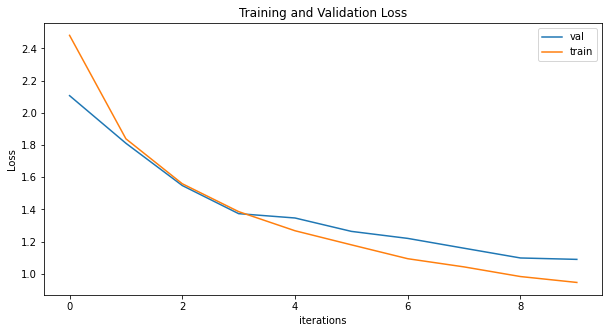

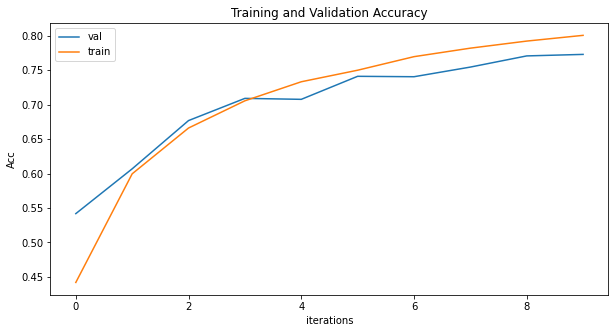

time: 6min 8s (started: 2022-09-28 01:48:29 +00:00)


In [ ]:
train_epoch_loss_history, val_epoch_loss_history = train_model(model, train_loader, val_loader, criterion, optimizer)


In [ ]:
model = GoogleNet()
model.load_state_dict(torch.load('/content/sample_data/optimized_model'))

<All keys matched successfully>

time: 228 ms (started: 2022-09-28 01:54:38 +00:00)


In [ ]:
num_test_samples = 10000
correct = 0

model.eval().cuda()

with  torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        # Make predictions.
        prediction, _, _ = model(inputs)

        # Retrieve predictions indexes.
        _, predicted_class = torch.max(prediction.data, 1)

        # Compute number of correct predictions.
        correct += (predicted_class == labels).float().sum().item()

test_accuracy = correct / num_test_samples

print('Test accuracy: {}'.format(test_accuracy))

Test accuracy: 0.7833
time: 2.97 s (started: 2022-09-28 01:54:38 +00:00)


time: 2.98 s (started: 2022-09-28 01:54:38 +00:00)
